In [43]:
import os
import shutil
import random

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import shutil
import random

In [8]:
base_dir = r"C:\Users\sriva\Desktop\surya - ml_cbp\dataset"

In [30]:
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'Pneumonia'), exist_ok=True)

In [31]:
def split_data(base_dir, split_ratio=(0.85, 0.10, 0.05)):
    categories = ['Normal', 'Pneumonia']
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        images = os.listdir(category_dir)
        random.shuffle(images)
        
        total_images = len(images)
        train_size = int(total_images * split_ratio[0])
        val_size = int(total_images * split_ratio[1])
        
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        
        for image in train_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(base_dir, 'train', category, image))
        for image in val_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(base_dir, 'val', category, image))
        for image in test_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(base_dir, 'test', category, image))

In [32]:
split_data(base_dir)

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int' 
)

Found 4977 files belonging to 2 classes.


In [35]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

Found 294 files belonging to 2 classes.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

Found 585 files belonging to 2 classes.


In [37]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

In [38]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [16]:
train_dir = r"C:\Users\sriva\Desktop\surya - ml_cbp\dataset\train"
val_dir = r"C:\Users\sriva\Desktop\surya - ml_cbp\dataset\val"
test_dir = r"C:\Users\sriva\Desktop\surya - ml_cbp\dataset\test"

In [80]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [49]:
def extract_color_histogram(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [50]:
def prepare_dataset(base_dir):
    data = []
    labels = []
    for category in ['Normal', 'Pneumonia']:
        category_dir = os.path.join(base_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            features = extract_color_histogram(file_path)
            if features is not None:
                data.append(features)
                labels.append(category)
    return np.array(data), np.array(labels)

In [51]:
train_data, train_labels = prepare_dataset(train_dir)
val_data, val_labels = prepare_dataset(val_dir)
test_data, test_labels = prepare_dataset(test_dir)

print('Train data shape:', train_data.shape)
print('Validation data shape:', val_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (4977, 512)
Validation data shape: (585, 512)
Test data shape: (294, 512)


In [52]:
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
val_labels_encoded = le.transform(val_labels)
test_labels_encoded = le.transform(test_labels)

In [53]:
svm = SVC(kernel='linear')
svm.fit(train_data, train_labels_encoded)

SVC(kernel='linear')

In [73]:
val_predictions = svm.predict(val_data)
val_accuracy_svc = accuracy_score(val_labels_encoded, val_predictions)
print(f'Validation Accuracy: {val_accuracy_svc:.3f}')

Validation Accuracy: 0.846


In [74]:
test_predictions = svm.predict(test_data)
test_accuracy_svc = accuracy_score(test_labels_encoded, test_predictions)
print(f'Test Accuracy: {test_accuracy_svc:.3f}')

Test Accuracy: 0.779


In [57]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [58]:
rf.fit(train_data, train_labels_encoded)

RandomForestClassifier(random_state=42)

In [68]:
val_predictions_rf = rf.predict(val_data)
val_accuracy_rf = accuracy_score(val_labels_encoded, val_predictions_rf)
print(f'Random Forest Validation Accuracy: {val_accuracy_rf:.3f}')

Random Forest Validation Accuracy: 0.892


In [69]:
test_predictions_rf = rf.predict(test_data)
test_accuracy_rf = accuracy_score(test_labels_encoded, test_predictions_rf)
print(f'Random Forest Test Accuracy: {test_accuracy_rf:.3f}')

Random Forest Test Accuracy: 0.864


In [62]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [63]:
gb.fit(train_data, train_labels_encoded)

GradientBoostingClassifier(random_state=42)

In [70]:
val_predictions_gb = gb.predict(val_data)
val_accuracy_gb = accuracy_score(val_labels_encoded, val_predictions_gb)
print(f'Gradient Boosting Validation Accuracy: {val_accuracy_gb:.3f}')

Gradient Boosting Validation Accuracy: 0.899


In [71]:
test_predictions_gb = gb.predict(test_data)
test_accuracy_gb = accuracy_score(test_labels_encoded, test_predictions_gb)
print(f'Gradient Boosting Test Accuracy: {test_accuracy_gb:.3f}')

Gradient Boosting Test Accuracy: 0.867


In [33]:
batch_size = 32
img_height = 224
img_width = 224

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
156/156 [==============================] - 213s 1s/step - loss: 0.4713 - accuracy: 0.7969 - val_loss: 0.3387 - val_accuracy: 0.8530
Epoch 2/20
156/156 [==============================] - 177s 1s/step - loss: 0.2602 - accuracy: 0.8889 - val_loss: 0.2404 - val_accuracy: 0.8940
Epoch 3/20
156/156 [==============================] - 176s 1s/step - loss: 0.2069 - accuracy: 0.9158 - val_loss: 0.2081 - val_accuracy: 0.9231
Epoch 4/20
156/156 [==============================] - 178s 1s/step - loss: 0.1707 - accuracy: 0.9329 - val_loss: 0.2976 - val_accuracy: 0.8838
Epoch 5/20
156/156 [==============================] - 179s 1s/step - loss: 0.1218 - accuracy: 0.9514 - val_loss: 0.2156 - val_accuracy: 0.9299
Epoch 6/20
156/156 [==============================] - 187s 1s/step - loss: 0.1077 - accuracy: 0.9576 - val_loss: 0.2250 - val_accuracy: 0.9248
Epoch 7/20
156/156 [==============================] - 212s 1s/step - loss: 0.0879 - accuracy: 0.9662 - val_loss: 0.2937 - val_accuracy: 0.9094

In [75]:
test_loss, test_accuracy_cnn = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy_cnn}")

10/10 [==============================] - 2s 232ms/step - loss: 0.7217 - accuracy: 0.9286
Test Accuracy: 0.9285714030265808


In [87]:
val_loss, val_accuracy_cnn = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy_cnn}")

19/19 [==============================] - 5s 245ms/step - loss: 0.6321 - accuracy: 0.9179
Validation Accuracy: 0.9179487228393555


In [88]:
accuracies = [test_accuracy_svc,test_accuracy_rf,test_accuracy_gb,test_accuracy_cnn]
models = ["Support Vector Classifier","Random Forest","Gradiant boost algorithm","Convolution Neural Network"]

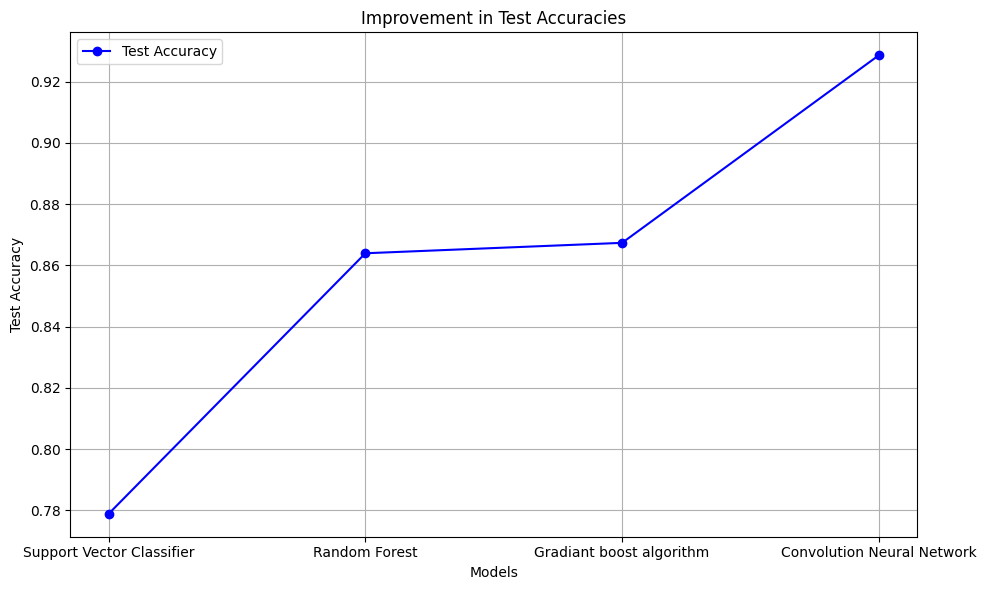

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Improvement in Test Accuracies')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()